In [1]:
##########################################################
#######################PROBLEM 1##########################
##########################################################


PROBLEM 1: YIELD CURVE FITTING

Problem 1a) Fitted continuously compounded spot rates:
Maturity:      0.5     1.0     2.0     5.0    10.0    15.0    20.0    30.0
Spot Rate:  0.03737  0.04352  0.05115  0.05666  0.05361  0.05102  0.04955  0.04804

Fit quality (SSE swap portion): 9.76e-25


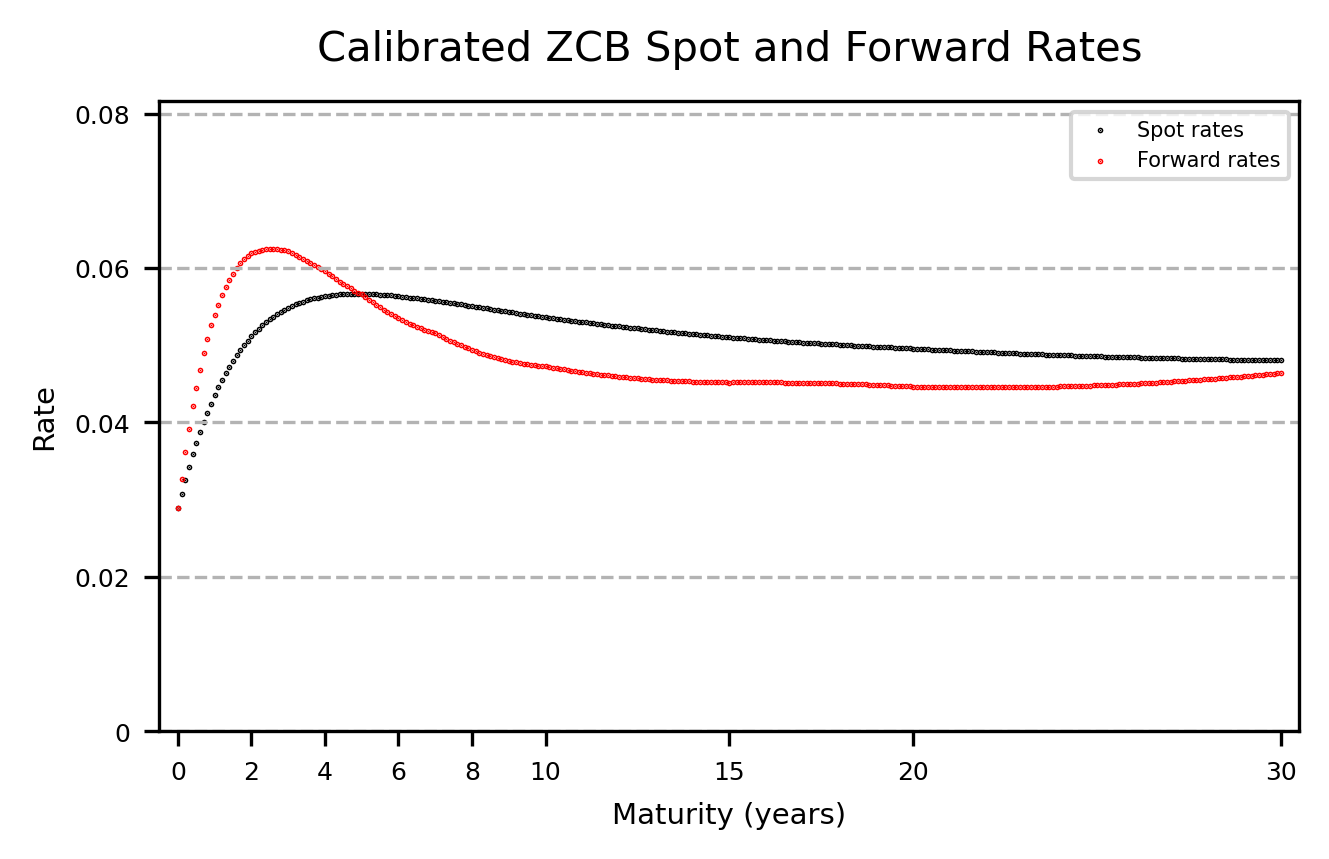


Problem 1c) 10Y par swap rate: 0.05539


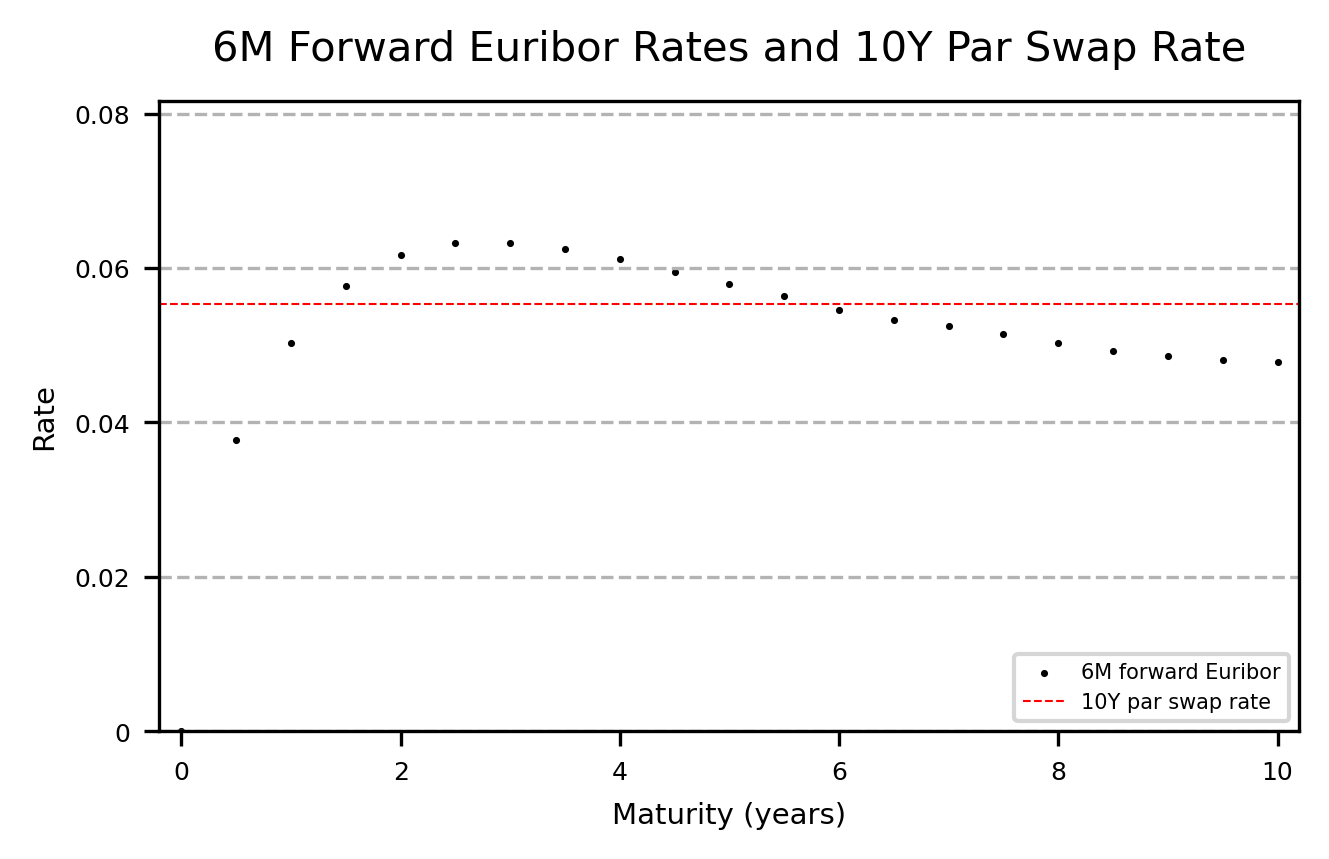


PROBLEM 2: INTEREST RATE CAP PRICING


In [5]:
# 1.a) 
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt

# Market data from exam
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03772}]

fra_market = [
    {"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.04026},
    {"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04261},
    {"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04477},
    {"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04677},
    {"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0486},
    {"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.05029},
    {"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.05183},
    {"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05324},
    {"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05452}
]

swap_market = [
    {"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05228, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05602, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05755, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05791, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05718, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05539, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05324, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05205, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
    {"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05087, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}
]

data_zcb = EURIBOR_fixing + fra_market + swap_market

# Caplet market data
alpha_caplet = 0.5
N_caplet = 21
T_caplet = np.array([i*alpha_caplet for i in range(0, N_caplet)])
strike_caplet_market = 0.055
price_caplet_market = np.array([0, 0, 3.592, 19.2679, 32.1887, 37.2136, 36.475, 32.2678, 26.9031, 
                                21.2176, 16.2022, 12.0628, 8.8952, 6.5191, 4.8435, 3.6485, 2.8098, 
                                2.2067, 1.7814, 1.4707, 1.2443])
price_caplet_market = price_caplet_market/10000

# Swaption market data
K_swaption_offset = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])
iv_swaption_market = np.array([0.220675, 0.18331, 0.155103, 0.129001, 0.10812, 0.084411, 0.071866, 
                                0.066535, 0.073942, 0.082751, 0.093605, 0.098971, 0.108909])

print("="*80)
print("PROBLEM 1: YIELD CURVE FITTING")
print("="*80)

# 1a) Fit yield curve
interpolation_options = {"method": "hermite", "degree": 3, "transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data_zcb, interpolation_options = interpolation_options, scaling = 1)

# Create interpolation grid
T_inter = np.linspace(0, 30, 301)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter, T_fit, R_fit, interpolation_options)

# Report specific spot rates
maturities_report = [0.5, 1, 2, 5, 10, 15, 20, 30]
R_report = fid.for_values_in_list_find_value_return_value(maturities_report, T_inter, R_inter)
print("\nProblem 1a) Fitted continuously compounded spot rates:")
print("Maturity:  ", "  ".join([f"{T:6.1f}" for T in maturities_report]))
print("Spot Rate: ", "  ".join([f"{R:.5f}" for R in R_report]))

# Check fit quality - compute SSE for swap portion
sse_swap = 0
for swap in swap_market:
    T_swap = swap["maturity"]
    R_market = swap["rate"]
    p_swap_fit = fid.for_values_in_list_find_value_return_value(T_swap, T_inter, p_inter)
    R_computed, S_computed = fid.swap_rate_from_zcb_prices(0, 0, T_swap, "annual", T_inter, p_inter)
    sse_swap += (R_market - R_computed)**2

print(f"\nFit quality (SSE swap portion): {sse_swap:.2e}")

# 1b) Plot term structures
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Calibrated ZCB Spot and Forward Rates", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10, 15, 20, 30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.5, xticks[-1]+0.5])
plt.xlabel(f"Maturity (years)", fontsize=7)
yticks = [0, 0.02, 0.04, 0.06, 0.08]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Rate", fontsize=7)
p1 = ax.scatter(T_inter, R_inter, s=0.5, color='black', marker=".", label="Spot rates")
p2 = ax.scatter(T_inter, f_inter, s=0.5, color='red', marker=".", label="Forward rates")
plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots, labels, loc="upper right", fontsize=5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_Spotrates.pdf")
plt.show()

# 1c) Compute 6M forward Euribor rates and 10Y par swap rate
T_10Y_swap = np.array([i*0.5 for i in range(0, 21)])
p_10Y_swap = fid.for_values_in_list_find_value_return_value(T_10Y_swap, T_inter, p_inter)
L_6M = np.zeros(len(T_10Y_swap))
for i in range(1, len(T_10Y_swap)):
    L_6M[i] = (p_10Y_swap[i-1]/p_10Y_swap[i] - 1)/0.5

R_10Y, S_10Y = fid.swap_rate_from_zcb_prices(0, 0, 10, "annual", T_inter, p_inter)
print(f"\nProblem 1c) 10Y par swap rate: {R_10Y:.5f}")

# Plot 6M forward Euribor rates
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"6M Forward Euribor Rates and 10Y Par Swap Rate", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.2, xticks[-1]+0.2])
plt.xlabel(f"Maturity (years)", fontsize=7)
yticks = [0, 0.02, 0.04, 0.06, 0.08]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Rate", fontsize=7)
p1 = ax.scatter(T_10Y_swap, L_6M, s=2, color='black', marker=".", label="6M forward Euribor")
ax.axhline(y=R_10Y, color='red', linewidth=0.5, linestyle='--', label="10Y par swap rate")
plots = [p1] + [plt.Line2D([0], [0], color='red', linewidth=0.5, linestyle='--')]
labels = ["6M forward Euribor", "10Y par swap rate"]
ax.legend(plots, labels, loc="lower right", fontsize=5)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_6M_forward_Euribor.pdf")
plt.show()

print("\n" + "="*80)
print("PROBLEM 2: INTEREST RATE CAP PRICING")
print("="*80)



Problem 2a)i) Fitted Vasicek parameters:
  r0 = 0.02640
  a = 2.41732
  b = 0.13208
  sigma = 0.02000
  SSE = 1.45e-04


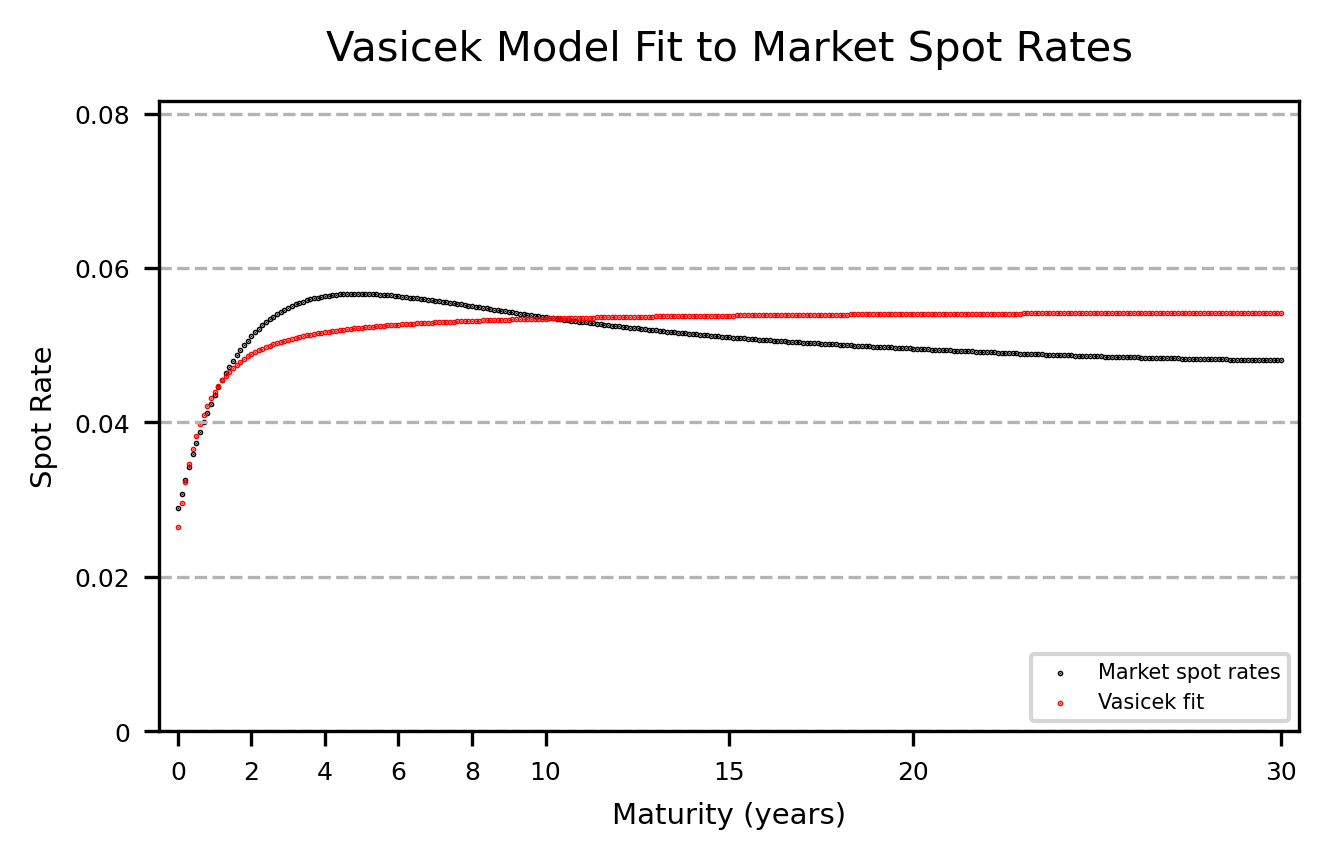


Problem 2b)ii) Fitted HWEV parameters:
  a = 2.03302
  sigma = 0.02031
  SSE = 5.03e-09


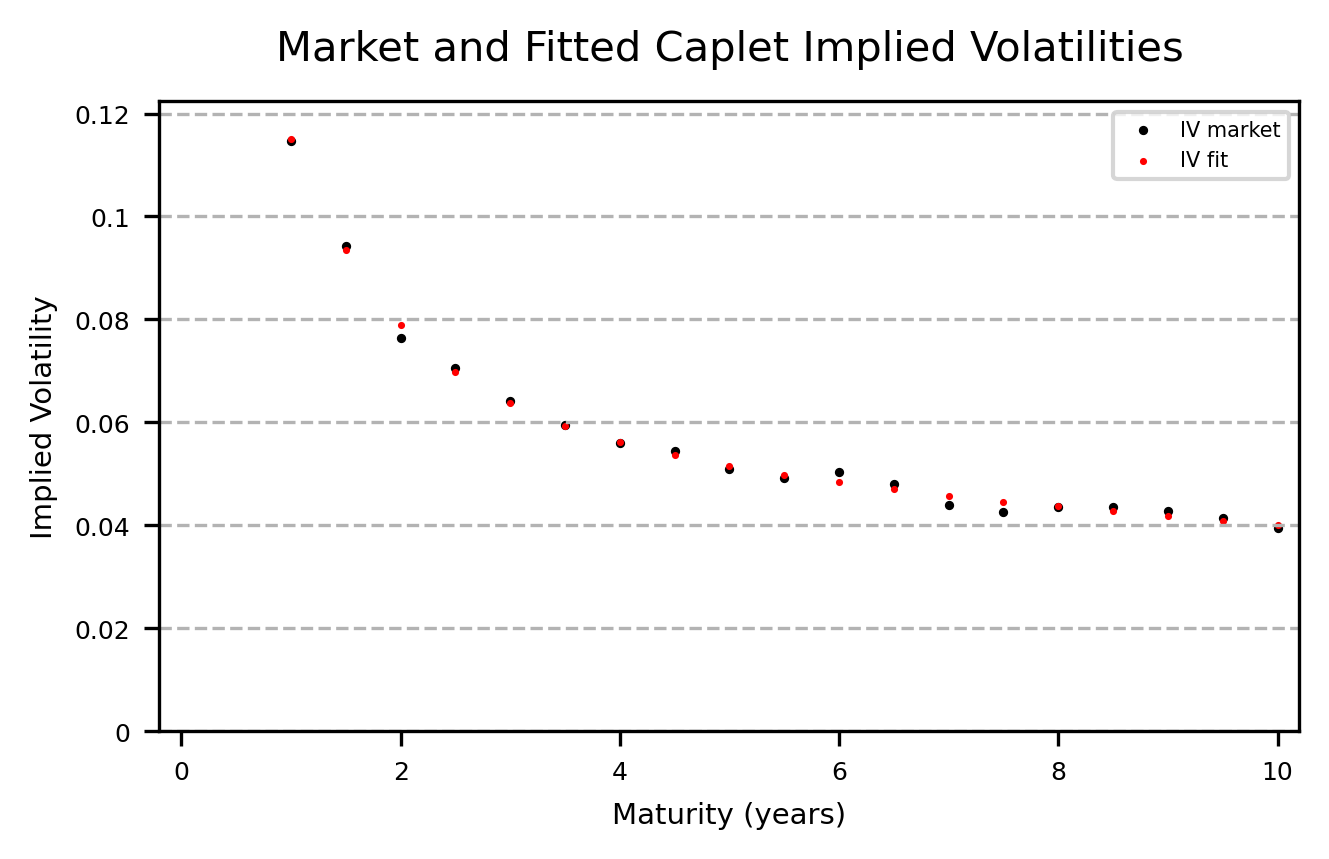

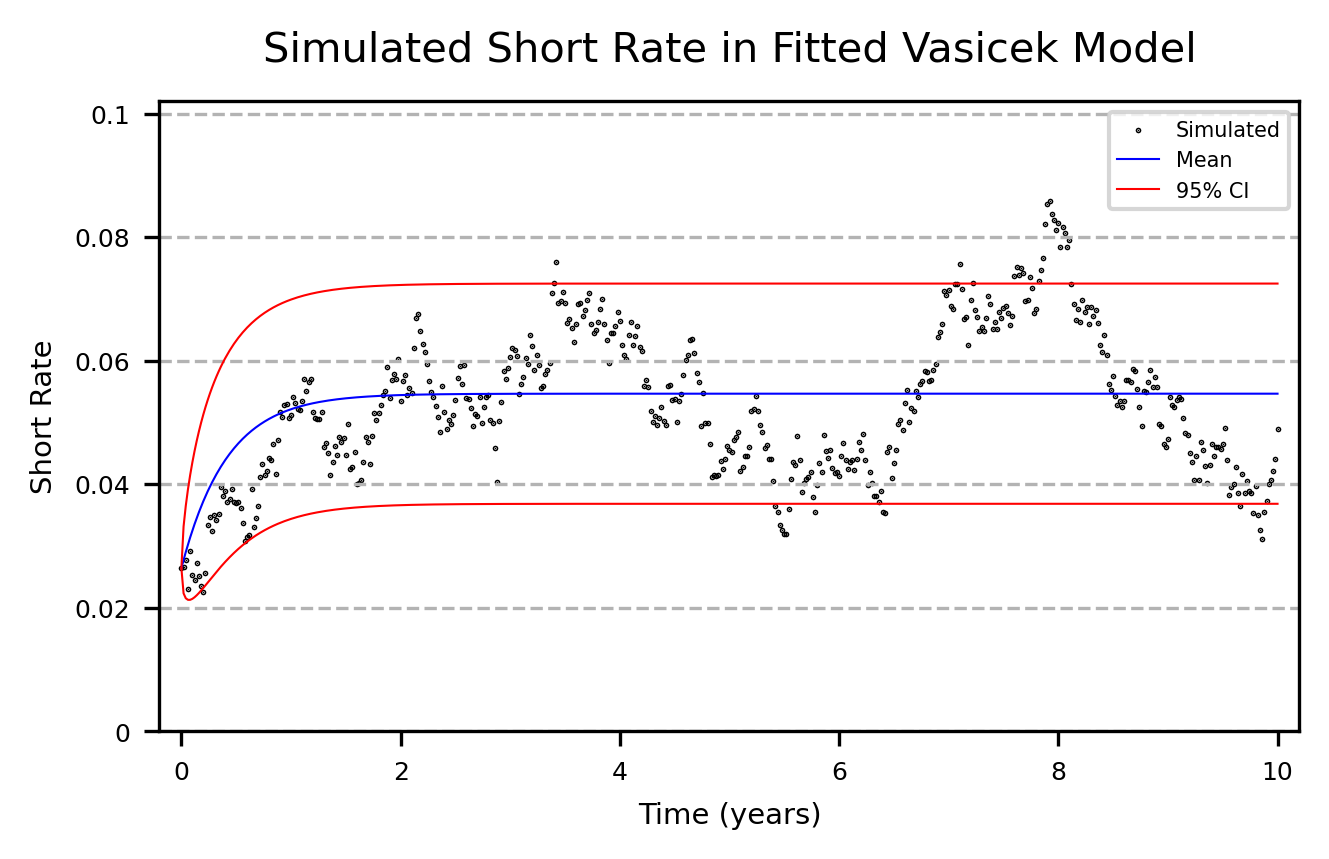

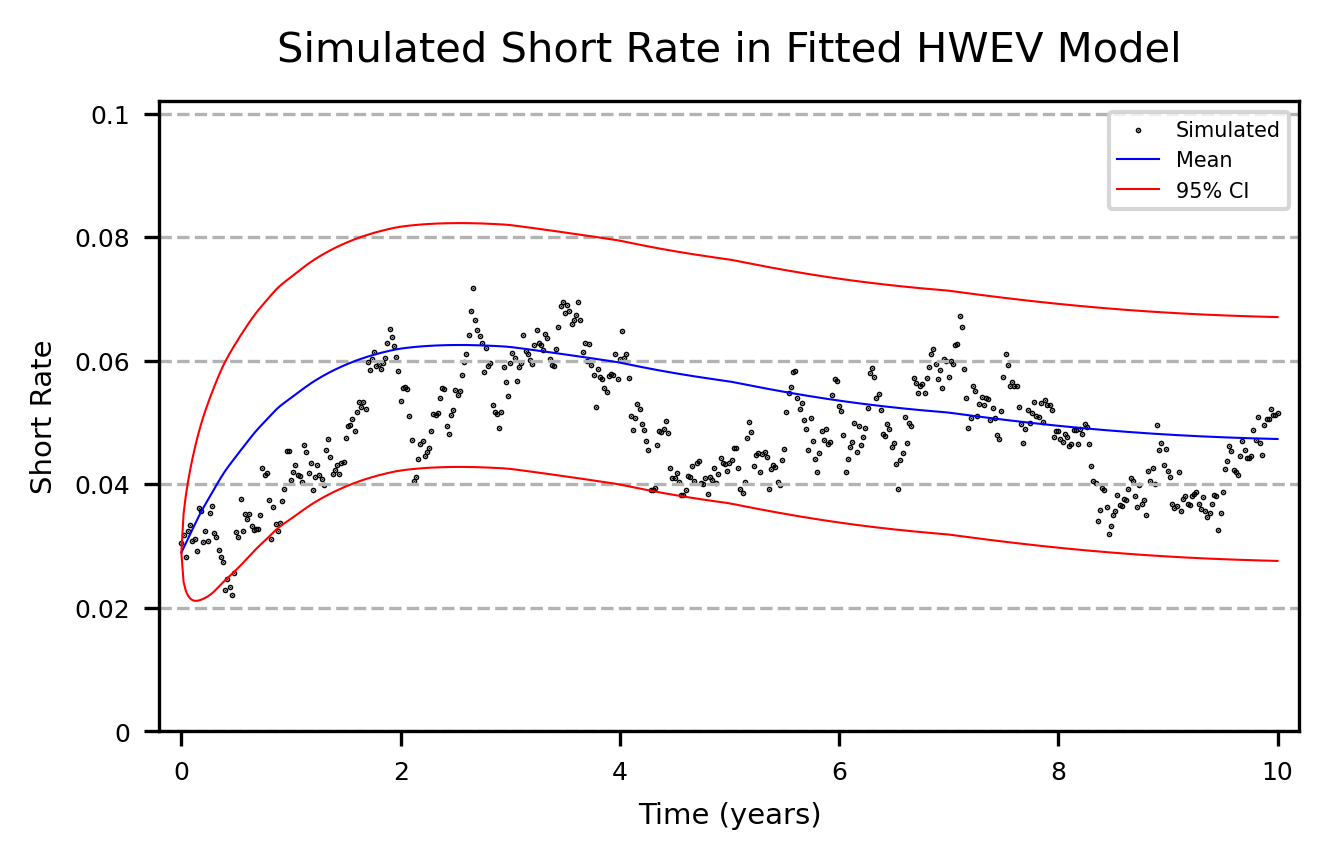


Problem 2d)i) Caplet prices for K=0.06 (in bps):
  T =  1:   0.6687 bps
  T =  2:  15.8546 bps
  T =  4:  12.8065 bps
  T =  6:   2.6277 bps
  T =  8:   0.6122 bps
  T = 10:   0.2263 bps

Problem 2d)ii) 10Y interest rate cap with K=0.06:
  Price (upfront): 120.37 bps
  Price (semi-annual premium): 15.8474 bps

PROBLEM 3: SWAPTION PRICING WITH SABR


In [6]:
# 2a) Fit Vasicek model
r0_init, a_init, b_init, sigma_vasicek = 0.035, 6, 0.25, 0.02

def vasicek_sse(params, T_fit, R_fit):
    r0, a, b = params
    R_vasicek = fid.spot_rate_vasicek(r0, a, b, sigma_vasicek, T_fit)
    return np.sum((R_vasicek - R_fit)**2)

result_vasicek = minimize(vasicek_sse, [r0_init, a_init, b_init], args=(T_fit, R_fit), 
                          method='nelder-mead', options={'disp': False})
r0_vasicek, a_vasicek, b_vasicek = result_vasicek.x

print(f"\nProblem 2a)i) Fitted Vasicek parameters:")
print(f"  r0 = {r0_vasicek:.5f}")
print(f"  a = {a_vasicek:.5f}")
print(f"  b = {b_vasicek:.5f}")
print(f"  sigma = {sigma_vasicek:.5f}")
print(f"  SSE = {result_vasicek.fun:.2e}")

# Plot Vasicek fit
R_vasicek = fid.spot_rate_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek, T_inter)

fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Vasicek Model Fit to Market Spot Rates", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10, 15, 20, 30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.5, xticks[-1]+0.5])
plt.xlabel(f"Maturity (years)", fontsize=7)
yticks = [0, 0.02, 0.04, 0.06, 0.08]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Spot Rate", fontsize=7)
p1 = ax.scatter(T_inter, R_inter, s=0.5, color='black', marker=".", label="Market spot rates")
p2 = ax.scatter(T_inter, R_vasicek, s=0.5, color='red', marker=".", label="Vasicek fit")
plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots, labels, loc="lower right", fontsize=5)
plt.show()

# 2b) Fit Hull-White Extended Vasicek (HWEV) model to caplet prices
r0 = R_fit[0]
a_init_hwev, sigma_init_hwev = 2.5, 0.018

def hwev_caplet_sse(params, strike, T_caplet, p_caplet, L_6M, price_caplet_market):
    a, sigma = params
    # Get forward rates and derivatives for Theta(t)
    f_market, f_T_market = fid.interpolate(T_caplet, T_fit, fid.forward_rates_from_zcb_prices(T_fit, 
                                           fid.zcb_prices_from_spot_rates(T_fit, R_fit), horizon=0), 
                                           interpolation_options)
    price_caplet_fit = fid.caplet_prices_hwev(strike, a, sigma, T_caplet, p_caplet)
    sse = np.sum((price_caplet_fit[2:] - price_caplet_market[2:])**2)
    return sse

result_hwev = minimize(hwev_caplet_sse, [a_init_hwev, sigma_init_hwev], 
                      args=(strike_caplet_market, T_caplet, p_10Y_swap, L_6M, price_caplet_market),
                      method='nelder-mead', options={'disp': False})
a_hwev, sigma_hwev = result_hwev.x

print(f"\nProblem 2b)ii) Fitted HWEV parameters:")
print(f"  a = {a_hwev:.5f}")
print(f"  sigma = {sigma_hwev:.5f}")
print(f"  SSE = {result_hwev.fun:.2e}")

# Compute fitted caplet prices and implied volatilities
price_caplet_fit = fid.caplet_prices_hwev(strike_caplet_market, a_hwev, sigma_hwev, T_caplet, p_10Y_swap)
iv_market = np.nan*np.ones(N_caplet)
iv_fit = np.nan*np.ones(N_caplet)
for i in range(2, N_caplet):
    iv_market[i] = fid.black_caplet_iv(price_caplet_market[i], T_caplet[i], strike_caplet_market, 
                                      0.5, p_10Y_swap[i], L_6M[i], type_option="call", prec=1e-10)
    iv_fit[i] = fid.black_caplet_iv(price_caplet_fit[i], T_caplet[i], strike_caplet_market, 
                                   0.5, p_10Y_swap[i], L_6M[i], type_option="call", prec=1e-10)

# Plot implied volatilities
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Market and Fitted Caplet Implied Volatilities", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.2, xticks[-1]+0.2])
plt.xlabel(f"Maturity (years)", fontsize=7)
yticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Implied Volatility", fontsize=7)
p1 = ax.scatter(T_caplet, iv_market, s=6, color='black', marker=".", label="IV market")
p2 = ax.scatter(T_caplet, iv_fit, s=2, color='red', marker=".", label="IV fit")
plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots, labels, loc="upper right", fontsize=5)
plt.show()

# 2c) Simulate short rate trajectories
M_simul, T_simul = 500, 10
size_ci = 0.95
mesh_simul = T_simul/M_simul
t_simul = np.array([i*mesh_simul for i in range(0, M_simul+1)])

# Vasicek simulation
np.random.seed(2)
r_simul_vasicek = fid.simul_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek, M_simul, T_simul, method="euler")
mean_vasicek = fid.mean_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek, t_simul)
lb_vasicek, ub_vasicek = fid.ci_vasicek(r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek, t_simul, size_ci, type_ci="two_sided")

# HWEV simulation
f_simul, f_T_simul = fid.interpolate(t_simul, T_inter, f_inter, interpolation_options)
theta_hwev = fid.theta_hwev(t_simul, f_simul, f_T_simul, a_hwev, sigma_hwev)
r_simul_hwev = fid.simul_hwev(r0, t_simul, theta_hwev, a_hwev, sigma_hwev, method="euler")
mean_hwev, var_hwev = fid.mean_var_hwev(a_hwev, sigma_hwev, t_simul, f_simul, f_T_simul)
lb_hwev, ub_hwev = fid.ci_hwev(a_hwev, sigma_hwev, t_simul, f_simul, f_T_simul, size_ci, type_ci="two_sided")

# Plot Vasicek simulation
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Simulated Short Rate in Fitted Vasicek Model", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.2, xticks[-1]+0.2])
plt.xlabel(f"Time (years)", fontsize=7)
yticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short Rate", fontsize=7)
p1 = ax.scatter(t_simul, r_simul_vasicek, s=0.5, color='black', marker=".", label="Simulated")
p2 = ax.plot(t_simul, mean_vasicek, color='blue', linewidth=0.5, label="Mean")[0]
p3 = ax.plot(t_simul, lb_vasicek, color='red', linewidth=0.5, label="95% CI")[0]
p4 = ax.plot(t_simul, ub_vasicek, color='red', linewidth=0.5)[0]
plots = [p1, p2, p3]
labels = ["Simulated", "Mean", "95% CI"]
ax.legend(plots, labels, loc="upper right", fontsize=5)
plt.show()

# Plot HWEV simulation
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Simulated Short Rate in Fitted HWEV Model", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.2, xticks[-1]+0.2])
plt.xlabel(f"Time (years)", fontsize=7)
yticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short Rate", fontsize=7)
p1 = ax.scatter(t_simul, r_simul_hwev, s=0.5, color='black', marker=".", label="Simulated")
p2 = ax.plot(t_simul, mean_hwev, color='blue', linewidth=0.5, label="Mean")[0]
p3 = ax.plot(t_simul, lb_hwev, color='red', linewidth=0.5, label="95% CI")[0]
p4 = ax.plot(t_simul, ub_hwev, color='red', linewidth=0.5)[0]
plots = [p1, p2, p3]
labels = ["Simulated", "Mean", "95% CI"]
ax.legend(plots, labels, loc="upper right", fontsize=5)
plt.show()

# 2d) Price 10Y interest rate cap with strike K=0.06
strike_cap = 0.06
T_cap = 10
M_cap = int(T_cap/alpha_caplet)
T_cap_payments = np.array([i*alpha_caplet for i in range(0, M_cap+1)])
p_cap = fid.for_values_in_list_find_value_return_value(T_cap_payments, T_inter, p_inter)

# Compute caplet prices using HWEV model
price_caplet_06 = fid.caplet_prices_hwev(strike_cap, a_hwev, sigma_hwev, T_cap_payments, p_cap)

print(f"\nProblem 2d)i) Caplet prices for K=0.06 (in bps):")
maturities_cap_report = [1, 2, 4, 6, 8, 10]
for T_cap_report in maturities_cap_report:
    idx = int(T_cap_report/alpha_caplet)
    print(f"  T = {T_cap_report:2d}: {10000*price_caplet_06[idx]:8.4f} bps")

# Price of 10Y cap
price_cap = np.sum(price_caplet_06[2:])  # Start from T=1
S_cap = fid.accrual_factor_from_zcb_prices(0, 0, T_cap, "semiannual", T_inter, p_inter)
premium_cap = price_cap/S_cap

print(f"\nProblem 2d)ii) 10Y interest rate cap with K=0.06:")
print(f"  Price (upfront): {10000*price_cap:.2f} bps")
print(f"  Price (semi-annual premium): {10000*premium_cap:.4f} bps")

print("\n" + "="*80)
print("PROBLEM 3: SWAPTION PRICING WITH SABR")
print("="*80)



Problem 3a)ii) 3Y7Y forward par swap rate: 0.05503

Problem 3a)iii) Swaption closest to K=0.06:
  Strike: 0.06003
  Price: 41.20 bps


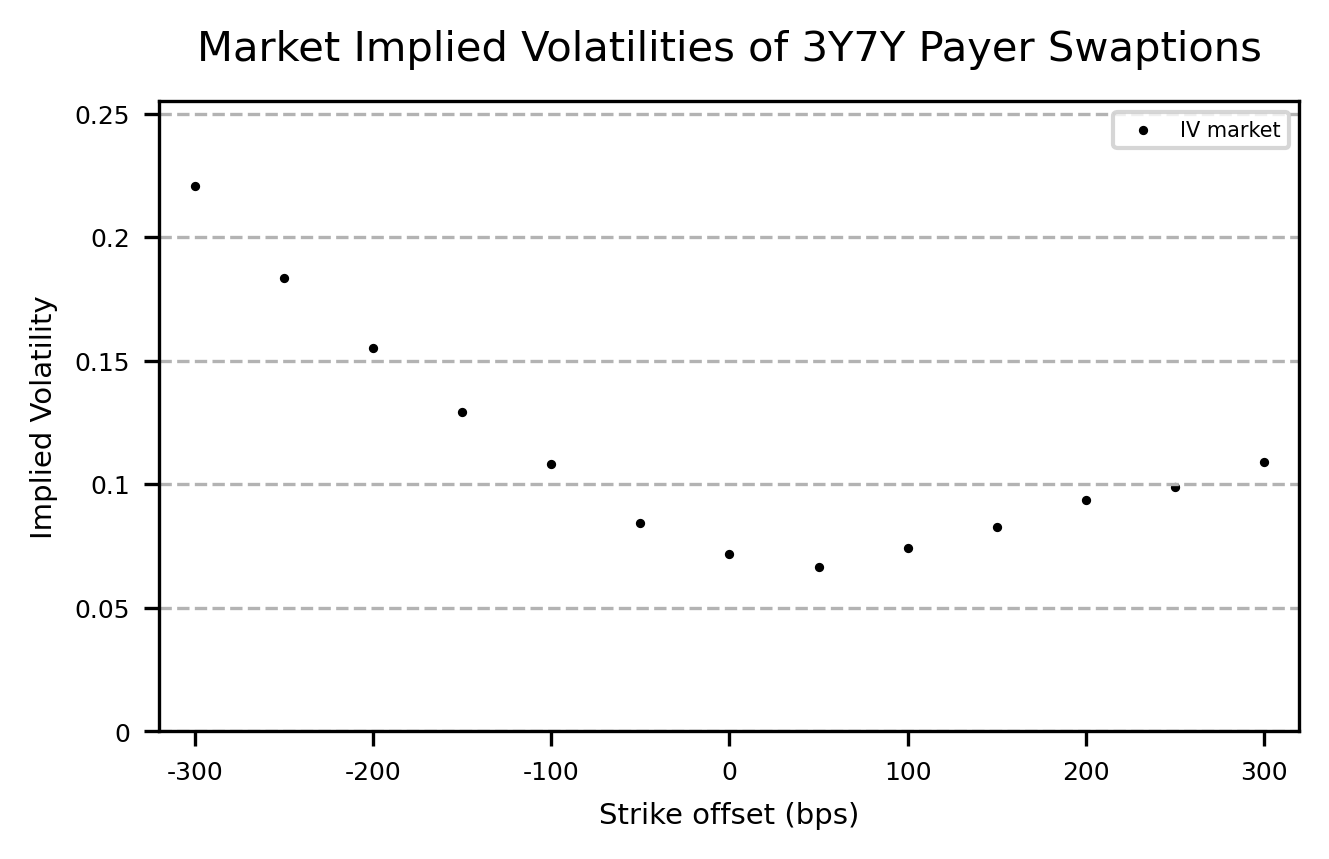


Problem 3b)i) Fitted SABR parameters:
  sigma_0 = 0.01788
  beta = 0.55 (fixed)
  upsilon = 0.58402
  rho = -0.34392
  SSE = 2.80e-05


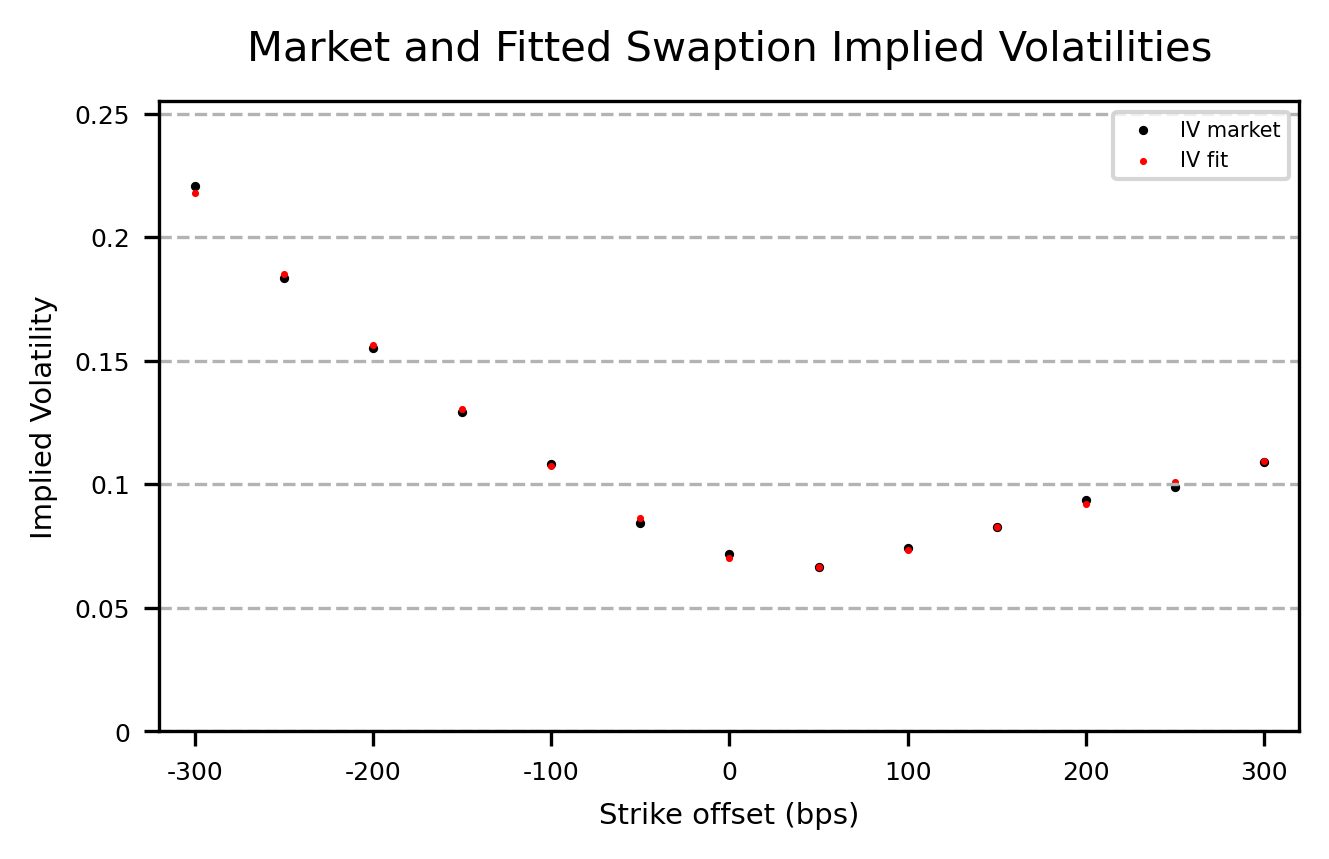


Problem 3c)ii) Strangle pricing and sensitivities:
  Base price: 47.4771 bps
  Delta (F0 +1bp): 0.0075 bps
  Delta (F0 -1bp): 0.0038 bps
  Vega (sigma_0 +0.001): 6.1277 bps
  Vega (sigma_0 -0.001): -5.7893 bps

PROBLEM 4: COMPARISON OF HEDGING STRATEGIES

Problem 4a) Summary of three options:
  Option 1 - 10Y payer swap rate: 0.05539
  Option 2 - 10Y cap price (upfront): 120.37 bps
  Option 2 - 10Y cap price (semi-annual premium): 15.8474 bps
  Option 3 - 3Y7Y swaption strike: 0.06003
  Option 3 - 3Y7Y swaption price: 41.20 bps

PROBLEM 5: TWO-FACTOR SHORT RATE MODEL


In [7]:

# 3a) Analyze swaption implied volatilities
# Compute 3Y7Y forward par swap rate
T_n, T_N = 3, 10
R_3Y7Y, S_3Y7Y = fid.swap_rate_from_zcb_prices(0, T_n, T_N, "annual", T_inter, p_inter)

print(f"\nProblem 3a)ii) 3Y7Y forward par swap rate: {R_3Y7Y:.5f}")

# Find strike closest to 0.06
K_swaption = R_3Y7Y + K_swaption_offset/10000
idx_closest = np.argmin(np.abs(K_swaption - 0.06))
K_closest = K_swaption[idx_closest]
price_swaption_closest = fid.black_swaption_price(iv_swaption_market[idx_closest], T_n, K_closest, 
                                                   S_3Y7Y, R_3Y7Y, type_option="call")

print(f"\nProblem 3a)iii) Swaption closest to K=0.06:")
print(f"  Strike: {K_closest:.5f}")
print(f"  Price: {10000*price_swaption_closest:.2f} bps")

# Plot implied volatilities
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Market Implied Volatilities of 3Y7Y Payer Swaptions", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [-300, -200, -100, 0, 100, 200, 300]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-20, xticks[-1]+20])
plt.xlabel(f"Strike offset (bps)", fontsize=7)
yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Implied Volatility", fontsize=7)
p1 = ax.scatter(K_swaption_offset, iv_swaption_market, s=6, color='black', marker=".", label="IV market")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots, labels, loc="upper right", fontsize=5)
plt.show()

# 3b) Fit SABR model
beta = 0.55
sigma_0_init, upsilon_init, rho_init = 0.02, 0.5, -0.3

def sabr_iv_sse(params, K, T, F0, beta, iv_market):
    sigma_0, upsilon, rho = params
    iv_fit = np.zeros(len(K))
    for i in range(len(K)):
        iv_fit[i] = fid.sigma_sabr(K[i], T, F0, sigma_0, beta, upsilon, rho)
    sse = np.sum((iv_fit - iv_market)**2)
    return sse

result_sabr = minimize(sabr_iv_sse, [sigma_0_init, upsilon_init, rho_init], 
                       args=(K_swaption, T_n, R_3Y7Y, beta, iv_swaption_market),
                       method='nelder-mead', options={'disp': False})
sigma_0_sabr, upsilon_sabr, rho_sabr = result_sabr.x

print(f"\nProblem 3b)i) Fitted SABR parameters:")
print(f"  sigma_0 = {sigma_0_sabr:.5f}")
print(f"  beta = {beta:.2f} (fixed)")
print(f"  upsilon = {upsilon_sabr:.5f}")
print(f"  rho = {rho_sabr:.5f}")
print(f"  SSE = {result_sabr.fun:.2e}")

# Compute fitted implied volatilities
iv_sabr_fit = np.zeros(len(K_swaption))
for i in range(len(K_swaption)):
    iv_sabr_fit[i] = fid.sigma_sabr(K_swaption[i], T_n, R_3Y7Y, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)

# Plot fitted volatilities
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Market and Fitted Swaption Implied Volatilities", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [-300, -200, -100, 0, 100, 200, 300]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-20, xticks[-1]+20])
plt.xlabel(f"Strike offset (bps)", fontsize=7)
yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Implied Volatility", fontsize=7)
p1 = ax.scatter(K_swaption_offset, iv_swaption_market, s=6, color='black', marker=".", label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_sabr_fit, s=2, color='red', marker=".", label="IV fit")
plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots, labels, loc="upper right", fontsize=5)
plt.show()

# 3c) Price strangle and compute sensitivities
K_call = R_3Y7Y + 100/10000
K_put = R_3Y7Y - 100/10000

iv_call = fid.sigma_sabr(K_call, T_n, R_3Y7Y, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)
iv_put = fid.sigma_sabr(K_put, T_n, R_3Y7Y, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)

price_call = fid.black_swaption_price(iv_call, T_n, K_call, S_3Y7Y, R_3Y7Y, type_option="call")
price_put = fid.black_swaption_price(iv_put, T_n, K_put, S_3Y7Y, R_3Y7Y, type_option="put")
price_strangle = price_call + price_put

print(f"\nProblem 3c)ii) Strangle pricing and sensitivities:")
print(f"  Base price: {10000*price_strangle:.4f} bps")

# Bump F0
F0_up = R_3Y7Y + 0.0001
F0_down = R_3Y7Y - 0.0001

iv_call_F_up = fid.sigma_sabr(K_call, T_n, F0_up, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)
iv_put_F_up = fid.sigma_sabr(K_put, T_n, F0_up, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)
price_strangle_F_up = fid.black_swaption_price(iv_call_F_up, T_n, K_call, S_3Y7Y, F0_up, type_option="call") + \
                      fid.black_swaption_price(iv_put_F_up, T_n, K_put, S_3Y7Y, F0_up, type_option="put")

iv_call_F_down = fid.sigma_sabr(K_call, T_n, F0_down, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)
iv_put_F_down = fid.sigma_sabr(K_put, T_n, F0_down, sigma_0_sabr, beta, upsilon_sabr, rho_sabr)
price_strangle_F_down = fid.black_swaption_price(iv_call_F_down, T_n, K_call, S_3Y7Y, F0_down, type_option="call") + \
                        fid.black_swaption_price(iv_put_F_down, T_n, K_put, S_3Y7Y, F0_down, type_option="put")

print(f"  Delta (F0 +1bp): {10000*(price_strangle_F_up - price_strangle):.4f} bps")
print(f"  Delta (F0 -1bp): {10000*(price_strangle_F_down - price_strangle):.4f} bps")

# Bump sigma_0
sigma_0_up = sigma_0_sabr + 0.001
sigma_0_down = sigma_0_sabr - 0.001

iv_call_sig_up = fid.sigma_sabr(K_call, T_n, R_3Y7Y, sigma_0_up, beta, upsilon_sabr, rho_sabr)
iv_put_sig_up = fid.sigma_sabr(K_put, T_n, R_3Y7Y, sigma_0_up, beta, upsilon_sabr, rho_sabr)
price_strangle_sig_up = fid.black_swaption_price(iv_call_sig_up, T_n, K_call, S_3Y7Y, R_3Y7Y, type_option="call") + \
                        fid.black_swaption_price(iv_put_sig_up, T_n, K_put, S_3Y7Y, R_3Y7Y, type_option="put")

iv_call_sig_down = fid.sigma_sabr(K_call, T_n, R_3Y7Y, sigma_0_down, beta, upsilon_sabr, rho_sabr)
iv_put_sig_down = fid.sigma_sabr(K_put, T_n, R_3Y7Y, sigma_0_down, beta, upsilon_sabr, rho_sabr)
price_strangle_sig_down = fid.black_swaption_price(iv_call_sig_down, T_n, K_call, S_3Y7Y, R_3Y7Y, type_option="call") + \
                          fid.black_swaption_price(iv_put_sig_down, T_n, K_put, S_3Y7Y, R_3Y7Y, type_option="put")

print(f"  Vega (sigma_0 +0.001): {10000*(price_strangle_sig_up - price_strangle):.4f} bps")
print(f"  Vega (sigma_0 -0.001): {10000*(price_strangle_sig_down - price_strangle):.4f} bps")

print("\n" + "="*80)
print("PROBLEM 4: COMPARISON OF HEDGING STRATEGIES")
print("="*80)

print("\nProblem 4a) Summary of three options:")
print(f"  Option 1 - 10Y payer swap rate: {R_10Y:.5f}")
print(f"  Option 2 - 10Y cap price (upfront): {10000*price_cap:.2f} bps")
print(f"  Option 2 - 10Y cap price (semi-annual premium): {10000*premium_cap:.4f} bps")
print(f"  Option 3 - 3Y7Y swaption strike: {K_closest:.5f}")
print(f"  Option 3 - 3Y7Y swaption price: {10000*price_swaption_closest:.2f} bps")

print("\n" + "="*80)
print("PROBLEM 5: TWO-FACTOR SHORT RATE MODEL")
print("="*80)



Problem 5c) Two-sided 95% CI bounds for T=1:
  Lower bound: 0.01337
  Upper bound: 0.06237

Problem 5c) Two-sided 95% CI bounds for T=10:
  Lower bound: 0.01956
  Upper bound: 0.08017


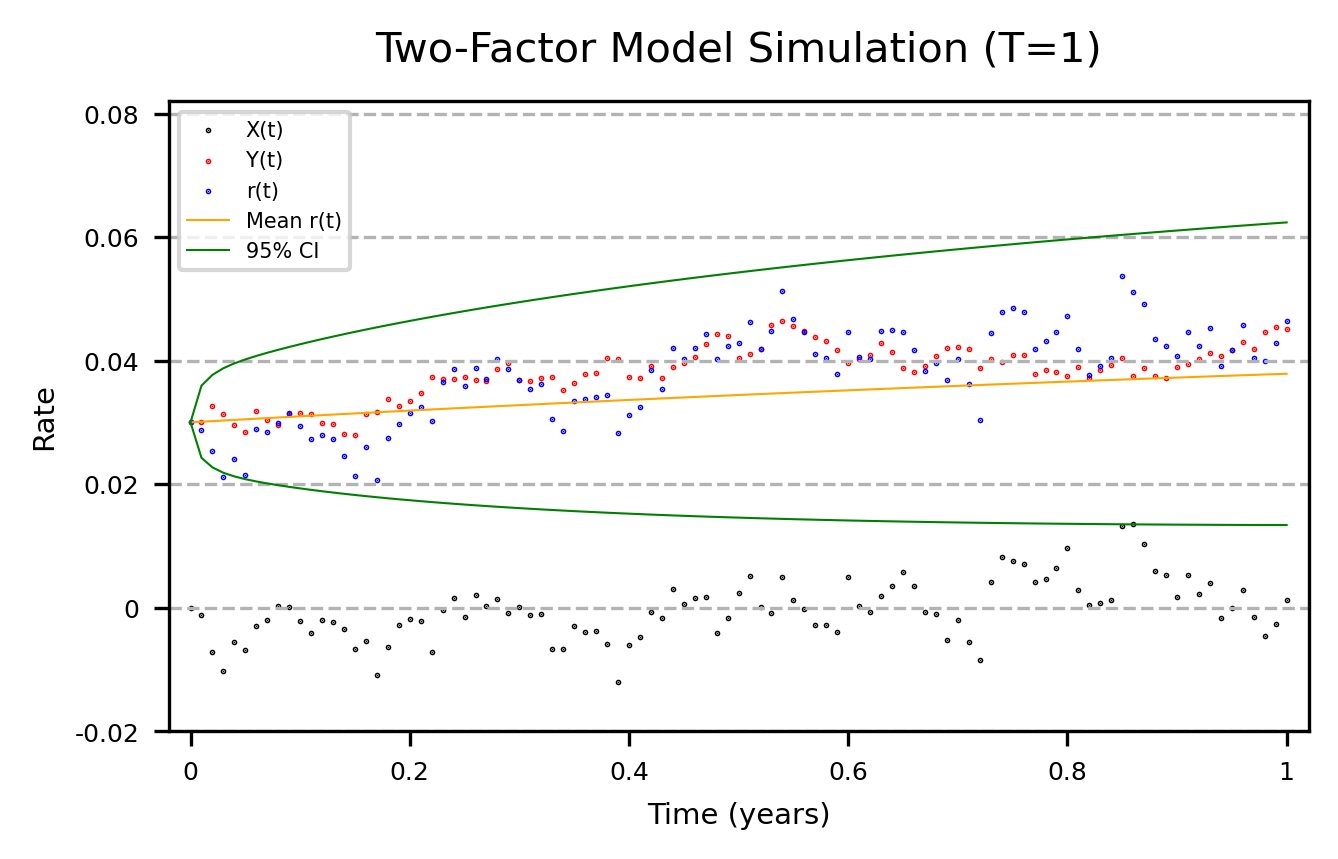

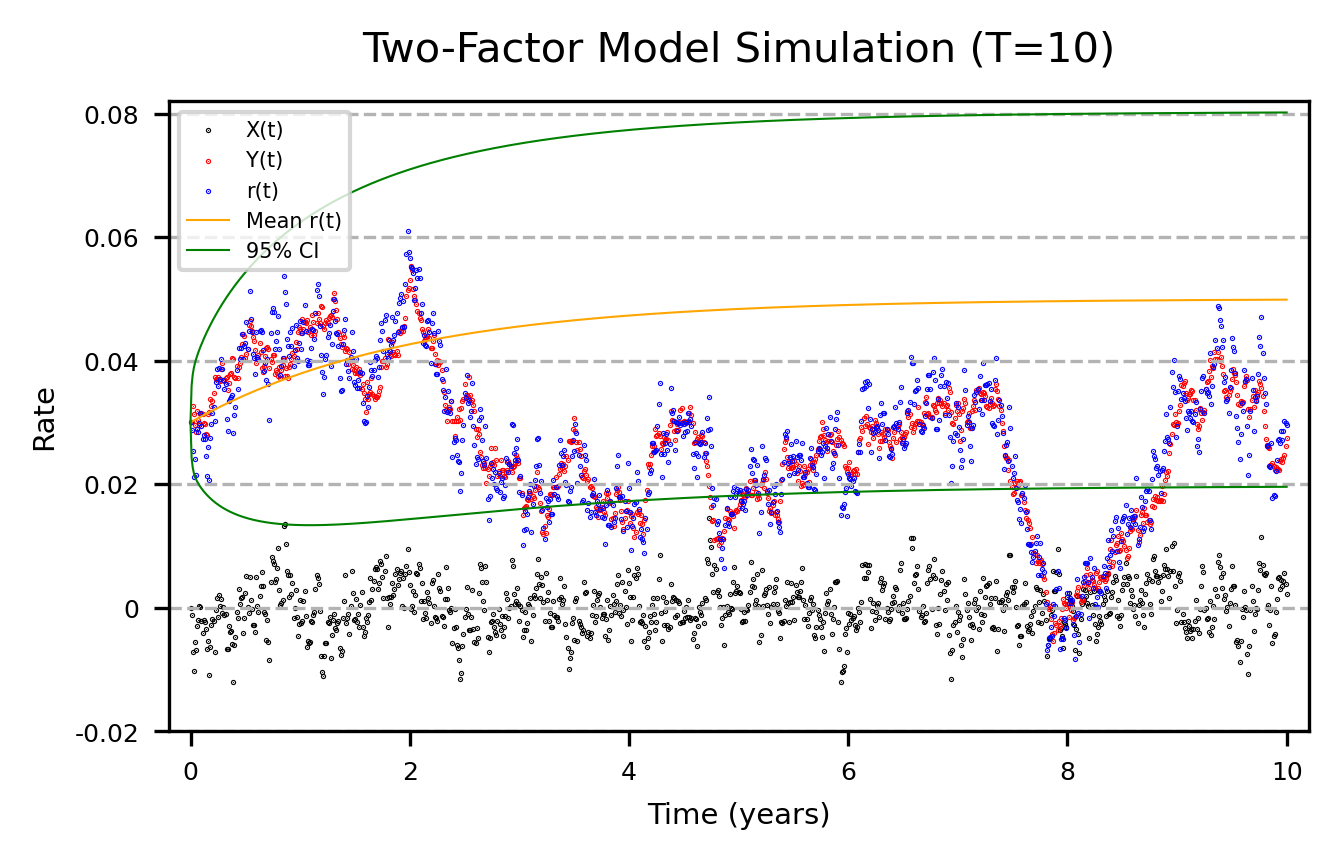


SOLUTION COMPLETED


In [8]:

# 5c) Simulate two-factor model
x0, gamma, phi = 0, 32, 0.03
y0, a, b, sigma_two_factor = 0.03, 0.5, 0.025, 0.015

# Short simulation (T=1)
M_short, T_short = 100, 1
mesh_short = T_short/M_short
t_short = np.array([i*mesh_short for i in range(0, M_short+1)])

np.random.seed(2)
X_short = np.zeros(M_short+1)
Y_short = np.zeros(M_short+1)
X_short[0], Y_short[0] = x0, y0

for m in range(1, M_short+1):
    Z1, Z2 = np.random.randn(2)
    X_short[m] = X_short[m-1] - gamma*X_short[m-1]*mesh_short + phi*np.sqrt(mesh_short)*Z1
    Y_short[m] = Y_short[m-1] + (b - a*Y_short[m-1])*mesh_short + sigma_two_factor*np.sqrt(mesh_short)*Z2

r_short = X_short + Y_short

# Compute mean and CI for short simulation
mean_X_short = x0*np.exp(-gamma*t_short)
mean_Y_short = y0*np.exp(-a*t_short) + (b/a)*(1 - np.exp(-a*t_short))
mean_r_short = mean_X_short + mean_Y_short

var_X_short = (phi**2/(2*gamma))*(1 - np.exp(-2*gamma*t_short))
var_Y_short = (sigma_two_factor**2/(2*a))*(1 - np.exp(-2*a*t_short))
var_r_short = var_X_short + var_Y_short
std_r_short = np.sqrt(var_r_short)

z_ci = norm.ppf(0.975)
lb_r_short = mean_r_short - z_ci*std_r_short
ub_r_short = mean_r_short + z_ci*std_r_short

print(f"\nProblem 5c) Two-sided 95% CI bounds for T=1:")
print(f"  Lower bound: {lb_r_short[-1]:.5f}")
print(f"  Upper bound: {ub_r_short[-1]:.5f}")

# Long simulation (T=10)
M_long, T_long = 1000, 10
mesh_long = T_long/M_long
t_long = np.array([i*mesh_long for i in range(0, M_long+1)])

np.random.seed(2)
X_long = np.zeros(M_long+1)
Y_long = np.zeros(M_long+1)
X_long[0], Y_long[0] = x0, y0

for m in range(1, M_long+1):
    Z1, Z2 = np.random.randn(2)
    X_long[m] = X_long[m-1] - gamma*X_long[m-1]*mesh_long + phi*np.sqrt(mesh_long)*Z1
    Y_long[m] = Y_long[m-1] + (b - a*Y_long[m-1])*mesh_long + sigma_two_factor*np.sqrt(mesh_long)*Z2

r_long = X_long + Y_long

# Compute mean and CI for long simulation
mean_X_long = x0*np.exp(-gamma*t_long)
mean_Y_long = y0*np.exp(-a*t_long) + (b/a)*(1 - np.exp(-a*t_long))
mean_r_long = mean_X_long + mean_Y_long

var_X_long = (phi**2/(2*gamma))*(1 - np.exp(-2*gamma*t_long))
var_Y_long = (sigma_two_factor**2/(2*a))*(1 - np.exp(-2*a*t_long))
var_r_long = var_X_long + var_Y_long
std_r_long = np.sqrt(var_r_long)

lb_r_long = mean_r_long - z_ci*std_r_long
ub_r_long = mean_r_long + z_ci*std_r_long

print(f"\nProblem 5c) Two-sided 95% CI bounds for T=10:")
print(f"  Lower bound: {lb_r_long[-1]:.5f}")
print(f"  Upper bound: {ub_r_long[-1]:.5f}")

# Plot short simulation
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Two-Factor Model Simulation (T=1)", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.02, xticks[-1]+0.02])
plt.xlabel(f"Time (years)", fontsize=7)
yticks = [-0.02, 0, 0.02, 0.04, 0.06, 0.08]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Rate", fontsize=7)
p1 = ax.scatter(t_short, X_short, s=0.5, color='black', marker=".", label="X(t)")
p2 = ax.scatter(t_short, Y_short, s=0.5, color='red', marker=".", label="Y(t)")
p3 = ax.scatter(t_short, r_short, s=0.5, color='blue', marker=".", label="r(t)")
p4 = ax.plot(t_short, mean_r_short, color='orange', linewidth=0.5, label="Mean r(t)")[0]
p5 = ax.plot(t_short, lb_r_short, color='green', linewidth=0.5, label="95% CI")[0]
p6 = ax.plot(t_short, ub_r_short, color='green', linewidth=0.5)[0]
plots = [p1, p2, p3, p4, p5]
labels = ["X(t)", "Y(t)", "r(t)", "Mean r(t)", "95% CI"]
ax.legend(plots, labels, loc="best", fontsize=5)
plt.show()

# Plot long simulation
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle(f"Two-Factor Model Simulation (T=10)", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.2, xticks[-1]+0.2])
plt.xlabel(f"Time (years)", fontsize=7)
yticks = [-0.02, 0, 0.02, 0.04, 0.06, 0.08]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([yticks[0], yticks[-1] + (yticks[-1]-yticks[0])*0.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Rate", fontsize=7)
p1 = ax.scatter(t_long, X_long, s=0.3, color='black', marker=".", label="X(t)")
p2 = ax.scatter(t_long, Y_long, s=0.3, color='red', marker=".", label="Y(t)")
p3 = ax.scatter(t_long, r_long, s=0.3, color='blue', marker=".", label="r(t)")
p4 = ax.plot(t_long, mean_r_long, color='orange', linewidth=0.5, label="Mean r(t)")[0]
p5 = ax.plot(t_long, lb_r_long, color='green', linewidth=0.5, label="95% CI")[0]
p6 = ax.plot(t_long, ub_r_long, color='green', linewidth=0.5)[0]
plots = [p1, p2, p3, p4, p5]
labels = ["X(t)", "Y(t)", "r(t)", "Mean r(t)", "95% CI"]
ax.legend(plots, labels, loc="best", fontsize=5)
plt.show()

print("\n" + "="*80)
print("SOLUTION COMPLETED")
print("="*80)
